# NYCU IEE Deep Learning Lab 01: Backpropagation
BSCHEN, 313510156

## Mount your google drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# You need to modify this part to the directory where your code is located
# %cd "/content/drive/MyDrive/DL_Lab1/"
%cd "/home/bschen/deep_learning/Lab_01"

/home/bschen/deep_learning/Lab_01


## Import packages


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import model

In [3]:
# Fix the random seed
np.random.seed(0)

## Load the data and label

In [4]:
train_load = np.loadtxt('./data/fmnist-train.csv', delimiter=',', dtype="int")
test_load = np.loadtxt('./data/fmnist-test.csv', delimiter=',', dtype="int")

train_data = train_load[:, 1:]
train_label = train_load[:, 0]
test_data = test_load

print(f"shape of train_data: {train_data.shape}")
print(f"shape of train_label: {train_label.shape}")
print(f"shape of test_data: {test_data.shape}")

shape of train_data: (60000, 784)
shape of train_label: (60000,)
shape of test_data: (10000, 784)


## Show the training data

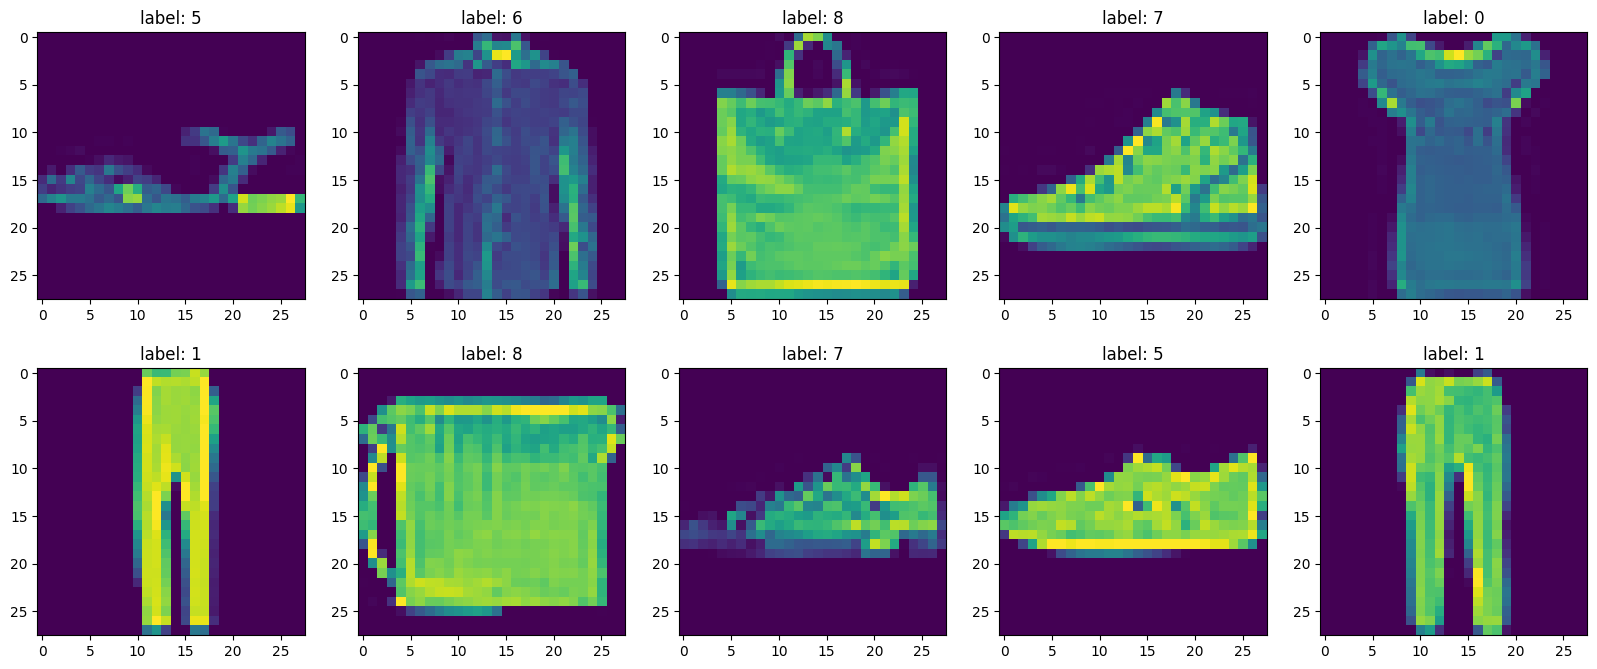

In [5]:
# Uncomment if you want to show the training data
plt.figure(figsize=(20, 8))
indices = np.random.choice(range(60000), size=10, replace=False).tolist()
for i, index in enumerate(indices):
    image = train_data[index].reshape(28, 28)
    plt.subplot(2, 5, i+1)
    plt.title(f"label: {train_label[index]}")
    plt.imshow(image)
plt.show()

In [6]:
train_image_num = train_data.shape[0]
test_image_num = test_data.shape[0]
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

print(f"train_image_num is : {train_image_num}")
print(f"test_image_num  is : {test_image_num}")

train_image_num is : 60000
test_image_num  is : 10000


## Validation image number

In [7]:
val_image_num = 10000

## Hyperparameters

In [ ]:
EPOCH = 200
BATCH_SIZE = 250  # 10000 should be divisible by batch_size
LEARNING_RATE = 1e-2

CHECKPOINT_PATH = "checkpoint.npy"
USE_CHECKPOINT = True

## Prepare for balance sampling in training dataset

In [10]:
n_train_iter = (train_image_num - val_image_num) // BATCH_SIZE
n_val_iter = val_image_num // BATCH_SIZE

# Sort by label
sorted_indices = np.argsort(train_label[:-val_image_num])
train_data[:-val_image_num] = train_data[sorted_indices]
train_label[:-val_image_num] = train_label[sorted_indices]

# Start index of each class
class_start_index, num_classes = [], []
for c in range(10):
    indices = (train_label[:-val_image_num] == c)
    num_classes.append(indices.sum().item())
    class_start_index.append(np.where(indices)[0][0].item())

# Show information
print(f"Number of training images is : {train_image_num - val_image_num}")
print(f"Number of validation images is : {val_image_num}")
print(f"Number of images in each class (in training set): {num_classes}")
print(f"Start index of each class: {class_start_index}")


Number of training images is : 50000
Number of validation images is : 10000
Number of images in each class (in training set): [5015, 4999, 5009, 4978, 5032, 5017, 5012, 4994, 4990, 4954]
Start index of each class: [0, 5015, 10014, 15023, 20001, 25033, 30050, 35062, 40056, 45046]


## Convert the training labels to one hot vector

In [11]:
label_temp = np.zeros((train_image_num, 10), dtype=np.float32)

for i in range(train_image_num):
    label_temp[i][train_label[i]] = 1
train_label_onehot = np.copy(label_temp)

print(f"One-hot training labels shape: {train_label_onehot.shape}")

One-hot training labels shape: (60000, 10)


## Initialization

In [ ]:
import os

# Create/Load log file
start_epoch = 0
if USE_CHECKPOINT and os.path.exists(CHECKPOINT_PATH) and os.path.exists("log.csv"):
    start_epoch = int(len(open("log.csv").readlines()) - 1)
    print(f"Resuming from epoch {start_epoch}...")
else:
    with open("log.csv", "w") as f:
        f.write("epoch, train_loss, train_acc, val_loss, val_acc, epoch_time\n")

# Initialize the model
net = model.Network()
net.center_loss.momentum = 1.0  # Initial value of center loss momentum
net.center_loss.lambda_c = 0.003  # Initial value of center loss lambda
if USE_CHECKPOINT and os.path.exists(CHECKPOINT_PATH):
    print("Loading checkpoint...")
    net.load_state_dict(np.load(CHECKPOINT_PATH, allow_pickle=True).item())

# Initialize the optimizer
optimizer = model.Adam(net.parameters(), lr=LEARNING_RATE)
if USE_CHECKPOINT and os.path.exists("optimizer.npy"):
    print("Loading optimizer state...")
    optimizer.load_state_dict(np.load("optimizer.npy", allow_pickle=True).item())

In [ ]:
# Data preprocessing
def preprocess(input_data: np.ndarray, transform: bool=True) -> np.ndarray:
    r""" Preprocess the input data and applying random transformations.
    - `input_data`: (batch_size, c * h * w)
    - `return`: (batch_size, c, h, w)
    """
    # Reshape and normalize
    batch_size = input_data.shape[0]
    images = input_data.reshape(batch_size, 1, 28, 28)  # (batch, 1, 28, 28)
    images = images / 255.0 - 0.5  # Normalize to [-0.5, 0.5]

    # Apply random transformations
    if transform:
        transformed = []
        for i in range(batch_size):
            transformed.append(random_transform(images[i]))
        transformed = np.stack(transformed, axis=0)  # (batch, 1, 28, 28)
    else:
        transformed = images

    return transformed

# Random transformation function
def random_transform(image: np.ndarray) -> np.ndarray:
    r""" Randomly transform the input image. """
    c, h, w = image.shape
    op = np.random.choice(["shift", "flip", "rotate", "none"])

    # Horizontal flip
    if op == "flip":
        image = np.flip(image, axis=2)

    # Translation
    elif op == "shift":
        pad = 6  # padding size
        image = np.pad(image, ((0, 0), (pad, pad), (pad, pad)), mode="constant", constant_values=-0.5)
        x, y = np.random.randint(0, 2 * pad), np.random.randint(0, 2 * pad)
        image = image[:, y:y+28, x:x+28]

    # Rotation
    elif op == "rotate":
        # Efficient vectorized rotation using numpy
        angle = np.random.uniform(-10, 10) * np.pi / 180.0
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        cx, cy = w // 2, h // 2

        # Create meshgrid for output coordinates
        y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        y_flat, x_flat = y.flatten(), x.flatten()

        # Compute corresponding input coordinates
        yy = (y_flat - cy) * cos_a + (x_flat - cx) * sin_a + cy
        xx = -(y_flat - cy) * sin_a + (x_flat - cx) * cos_a + cx

        # Bilinear interpolation weights
        y0, x0 = np.floor(yy).astype(int), np.floor(xx).astype(int)
        y1, x1 = y0 + 1, x0 + 1
        wy, wx = yy - y0, xx - x0

        # Clip indices to valid range
        y0_clip, x0_clip = np.clip(y0, 0, h - 1), np.clip(x0, 0, w - 1)
        y1_clip, x1_clip = np.clip(y1, 0, h - 1), np.clip(x1, 0, w - 1)

        transformed = np.zeros_like(image)
        v00 = image[0, y0_clip, x0_clip]
        v01 = image[0, y0_clip, x1_clip]
        v10 = image[0, y1_clip, x0_clip]
        v11 = image[0, y1_clip, x1_clip]
        val = (1 - wy) * (1 - wx) * v00 + (1 - wy) * wx * v01 + wy * (1 - wx) * v10 + wy * wx * v11
        transformed[0] = val.reshape(h, w)
        image = transformed

    # Brightness/Contrast adjustment
    brightness_factor = np.random.uniform(-0.2, 0.2)
    contrast_factor = np.random.uniform(0.8, 1.2)
    image = (image - np.mean(image)) * contrast_factor + np.mean(image) + brightness_factor
    image = np.clip(image, -0.5, 0.5)

    return image


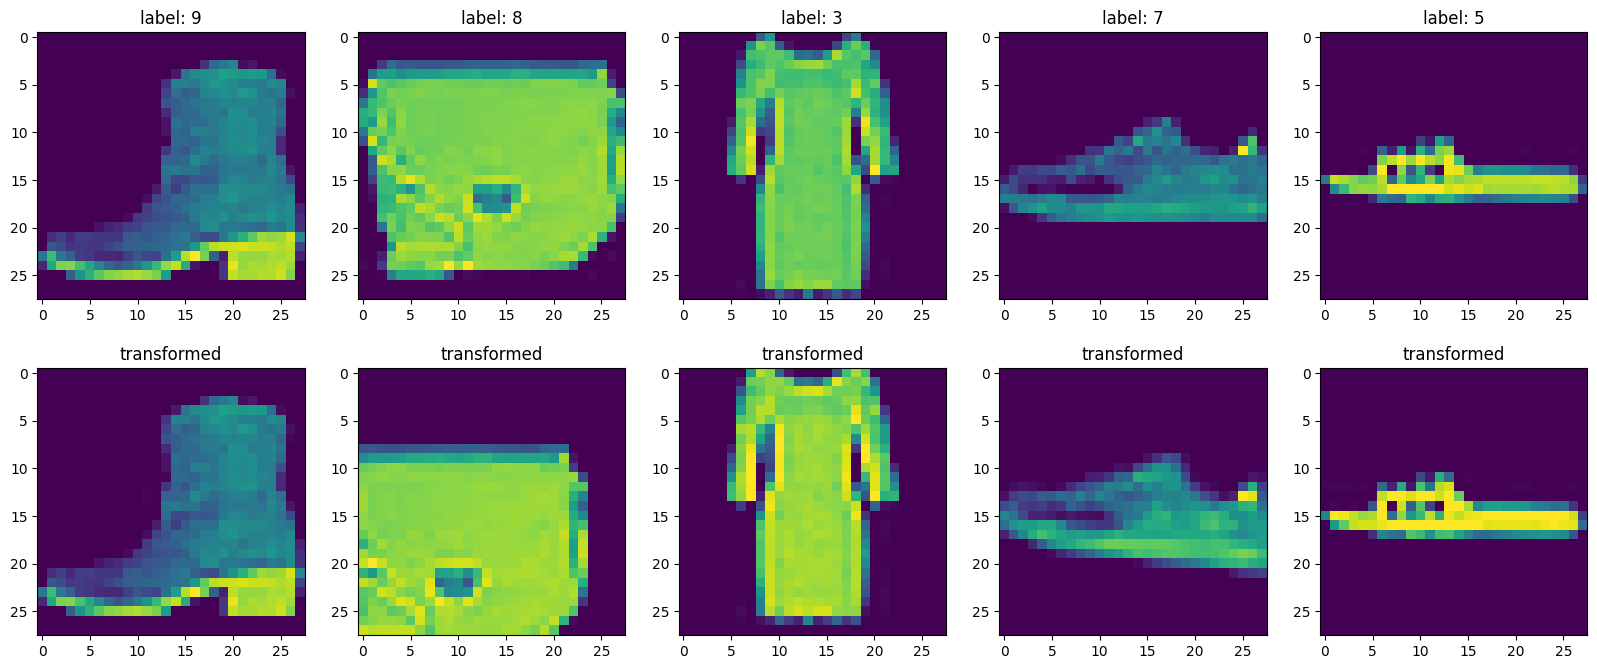

In [ ]:
plt.figure(figsize=(20, 8))
indices = np.random.choice(range(60000), size=5, replace=False).tolist()
for i, index in enumerate(indices):
    image = train_data[index].reshape(1, 28, 28) / 255.0 - 0.5
    transformed = ((random_transform(image) + 0.5) * 255.0).astype(np.uint8).reshape(28, 28)
    image = ((image + 0.5) * 255.0).astype(np.uint8).reshape(28, 28)
    plt.subplot(2, 5, i+1)
    plt.title(f"label: {train_label[index]}")
    plt.imshow(image)
    plt.subplot(2, 5, i+6)
    plt.title(f"transformed")
    plt.imshow(transformed)
plt.show()

## Training

In [ ]:
import time

best_acc = 0.0
epoch = start_epoch if start_epoch else 0
while epoch < EPOCH + 1:
    # Initialize
    train_hit, val_hit = 0, 0
    total_train_hit, total_val_hit = 0, 0
    total_train_loss, total_val_loss = 0.0, 0.0
    start_time = time.time()

    # Training
    net.train()
    for it in range(n_train_iter):
        # Preprocess input
        input_data_index = np.zeros((BATCH_SIZE,), dtype=np.int32)
        for cls in range(10):
            input_data_index[
                cls * (BATCH_SIZE // 10):(cls + 1) * (BATCH_SIZE // 10)
            ] = np.random.randint(
                class_start_index[cls], class_start_index[cls] + num_classes[cls],
                size=BATCH_SIZE // 10
            )
        input_data = preprocess(train_data[input_data_index], transform=False)

        # Forward, Backward, Update
        pred, train_loss = net.forward(
            input_data,
            train_label_onehot[input_data_index]
        )
        pred_index = np.argmax(pred, axis=1)
        train_hit = np.sum(pred_index == train_label[input_data_index])
        total_train_hit += train_hit
        total_train_loss += train_loss

        net.backward()
        optimizer.step(net.gradients())
        optimizer.zero_grad(net.gradients())
        net.center_loss.update()

    net.eval()
    for titt in range(n_val_iter):
        tit = n_train_iter + titt

        # Preprocess input
        input_data = preprocess(train_data[tit * BATCH_SIZE : (tit + 1) * BATCH_SIZE], transform=False)

        # Forward
        pred, val_loss = net.forward(
            input_data,
            train_label_onehot[tit * BATCH_SIZE : (tit + 1) * BATCH_SIZE]
        )
        pred_index = np.argmax(pred, axis=1)
        val_hit = np.sum(pred_index == train_label[tit * BATCH_SIZE : (tit + 1) * BATCH_SIZE])
        total_val_hit += val_hit
        total_val_loss += val_loss

    end_time = time.time()
    epoch_time = end_time - start_time
    print(
        f"Task-1 | Epoch:{epoch: 3d} |",
        f"Train Loss:{total_train_loss / n_train_iter: 8.4f} |",
        f"Train Acc:{total_train_hit / (train_image_num - val_image_num) * 100.0: 3.4f} |",
        f"Val Loss:{total_val_loss / n_val_iter: 8.4f} |",
        f"Val Acc:{total_val_hit / val_image_num * 100.0: 3.4f} |",
        f"Epoch time:{epoch_time: 5.2f} sec"
    )

    # Write log
    with open("log.csv", "a") as f:
        f.write(
            f"{epoch}, " +
            f"{total_train_loss / n_train_iter}, " +
            f"{total_train_hit / (train_image_num - val_image_num) * 100.0}, " +
            f"{total_val_loss / n_val_iter}, " +
            f"{total_val_hit / val_image_num * 100.0}, " +
            f"{epoch_time}\n"
        )

    # Parameter scheduling
    if epoch > 100 and epoch % 10 == 0:
        optimizer.lr = optimizer.lr * 0.5 if optimizer.lr > 1e-4 else 1e-4
    net.center_loss.lambda_c *= 1.05 if net.center_loss.lambda_c < 0.005 and epoch % 10 == 0 and epoch != 0 else 1
    net.center_loss.momentum *= 0.95 if net.center_loss.momentum > 0.01 else 1

    # Save model
    val_acc = total_val_hit / val_image_num
    if val_acc > best_acc and val_acc >= 0.92:
        print("Saving model...")
        np.save(CHECKPOINT_PATH, net.state_dict())
        np.save("optimizer.npy", optimizer.state_dict())
    best_acc = max(best_acc, val_acc)
    epoch += 1


## Dump for evaluation (upload your DL-test-predict.csv to kaggle )

In [ ]:
test_pred_list = []
total_test = 0
net.eval()
for tit in range(test_image_num // BATCH_SIZE):
    # Preprocess
    input_data = preprocess(test_data[tit * BATCH_SIZE:(tit + 1) * BATCH_SIZE], transform=False)

    # Forward
    pred, _ = net.forward(
        input_data,
        train_label_onehot[tit * BATCH_SIZE:(tit + 1) * BATCH_SIZE]
    )
    pred_index = np.argmax(pred, axis=1)
    test_pred_list += pred_index.tolist()
    total_test += BATCH_SIZE

print("Please make sure that total test images = 10000")
print(f"Total test images: {total_test} ")

print("Dump file...")
df = pd.DataFrame(test_pred_list, columns=["Category"])
df.to_csv(f"DL-test-predict.csv", index=True, index_label="Id")